<a href="https://colab.research.google.com/github/yuvalmargules/MI-LSTM/blob/master/MI-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
import requests
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

comps = ['CCL', 'AAPL', 'GOOG', 'NFLX', 'AMZN', 'MGM', 'CVX', 'BAC', 'BA', 'DAL']

input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
batch_size = 64
epochs = 20

window_size = 7
rate = .15

In [3]:
# Scraping data from wikipedia about the stocks
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        ticker = str.rstrip(ticker)
        tickers.append(ticker)

    return tickers


def get_data_from_yahoo(tickers):

    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()
    tickers_in = []
    tickers_out = []

    for ticker in tickers:
        ticker = str.rstrip(ticker)
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists(f'stock_dfs/{ticker}.csv'):
            try:
                df = web.DataReader(ticker, 'yahoo', start, end)
                tickers_in.append(ticker)
                df.to_csv(f'stock_dfs/{ticker}.csv')

            except:
                print(ticker)
                tickers_out.append(ticker)
            df.reset_index(inplace=True)
            df.set_index("Date", inplace=True)

        else:
            print(f'Already have {ticker}')

    print(f'{len(tickers_in)}/{len(tickers_in) + len(tickers_out)} Companies in S&P500 index are available')

    return tickers_out

def compile_data(tickers):

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        df = pd.read_csv(f'stock_dfs/{ticker}.csv')
        df.set_index('Date', inplace=True)

        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')

        if count % 100 == 0:
            print(f'{count}/{len(tickers)} Companies have been loaded')

    main_df.to_csv('sp500_joined_closes.csv')
    return main_df


In [4]:
# import all stocks belong to s&p500 index
df = pd.read_csv('https://raw.githubusercontent.com/yuvalmargules/MI-LSTM/master/sp500_joined_closes.csv')
# import s&p500 index
sp500 = pd.read_csv('https://raw.githubusercontent.com/yuvalmargules/MI-LSTM/master/sp500.csv')

# if data source is not available on GitHub
if len(df) == 0:
    tickers = save_sp500_tickers()
    tickers.remove('BF.B')
    tickers.remove('BRK.B')
    tickers_out = get_data_from_yahoo(tickers)

    try:
        df = pd.read_csv('sp500_joined_closes.csv')
    except:
        # data is not available - download it
        df = compile_data(tickers)

if len(sp500) == 0:
    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()

    sp500 = web.DataReader('^GSPC', 'yahoo', start, end)
    sp500.to_csv('stock_dfs/sp500.csv')

    sp500 = pd.read_csv('stock_dfs/sp500.csv')

df.head(), sp500.head()

(         Date        MMM        ABT  ABBV  ...       ZBRA        ZBH       ZION  ZTS
 0  2010-01-04  61.288338  20.074522   NaN  ...  28.670000  55.381721  11.648637  NaN
 1  2010-01-05  60.904442  19.912334   NaN  ...  28.620001  57.134892  12.059352  NaN
 2  2010-01-06  61.768192  20.022911   NaN  ...  28.400000  57.116451  13.107989  NaN
 3  2010-01-07  61.812481  20.188793   NaN  ...  27.690001  58.426708  14.576083  NaN
 4  2010-01-08  62.248039  20.292002   NaN  ...  27.600000  57.199497  14.340141  NaN
 
 [5 rows x 504 columns],
          Date         High          Low  ...        Close      Volume    Adj Close
 0  2010-01-04  1133.869995  1116.560059  ...  1132.989990  3991400000  1132.989990
 1  2010-01-05  1136.630005  1129.660034  ...  1136.520020  2491020000  1136.520020
 2  2010-01-06  1139.189941  1133.949951  ...  1137.140015  4972660000  1137.140015
 3  2010-01-07  1142.459961  1131.319946  ...  1141.689941  5270680000  1141.689941
 4  2010-01-08  1145.390015  1136.219

(MMM     0
 ABT     0
 ABMD    0
 ACN     0
 ATVI    0
        ..
 XLNX    0
 YUM     0
 ZBRA    0
 ZBH     0
 ZION    0
 Length: 448, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6c1ae0fe10>)

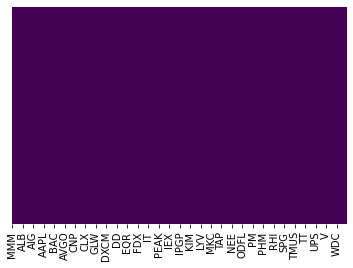

In [5]:
# data cleaning
sp500.set_index('Date', inplace=True)

sp500.rename(columns={'Adj Close': 'SP500'}, inplace=True)
sp500.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)

df = df.dropna(axis=1)
df = df.drop('Date', axis=1)

# heatmap on columns to make sure no null value left
df.isnull().sum(), sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Data Normalization

In [6]:
# Scaling
scaler = MinMaxScaler(feature_range=(-1,1))

names = df.columns
df_values = df.to_numpy()
# scaling each column at a time
df_values = np.array([scaler.fit_transform(col.reshape(-1, 1)) for col in df_values.T])
# reshaping for future usage
df_values = df_values.reshape(448,-1).T
# back to dataframe format with normalized data
df_norm = pd.DataFrame(df_values)
df_norm.columns = names
#normalaizing sp500 index
df_sp500 = pd.DataFrame(scaler.fit_transform(sp500))
df_sp500.columns = sp500.columns

df_norm.head(), df_sp500.head()

(        MMM       ABT      ABMD  ...      ZBRA       ZBH      ZION
 0 -0.926278 -0.947719 -0.996153  ... -0.982389 -0.801229 -1.000000
 1 -0.930583 -0.950639 -0.997103  ... -0.982593 -0.772290 -0.981799
 2 -0.920897 -0.948648 -0.997692  ... -0.983494 -0.772594 -0.935329
 3 -0.920400 -0.945661 -0.997692  ... -0.986402 -0.750965 -0.870270
 4 -0.915516 -0.943802 -0.998461  ... -0.986771 -0.771223 -0.880726
 
 [5 rows x 448 columns],       SP500
 0 -0.924175
 1 -0.921751
 2 -0.921325
 3 -0.918201
 4 -0.915941)

# Models
Implemented the same as in the paper

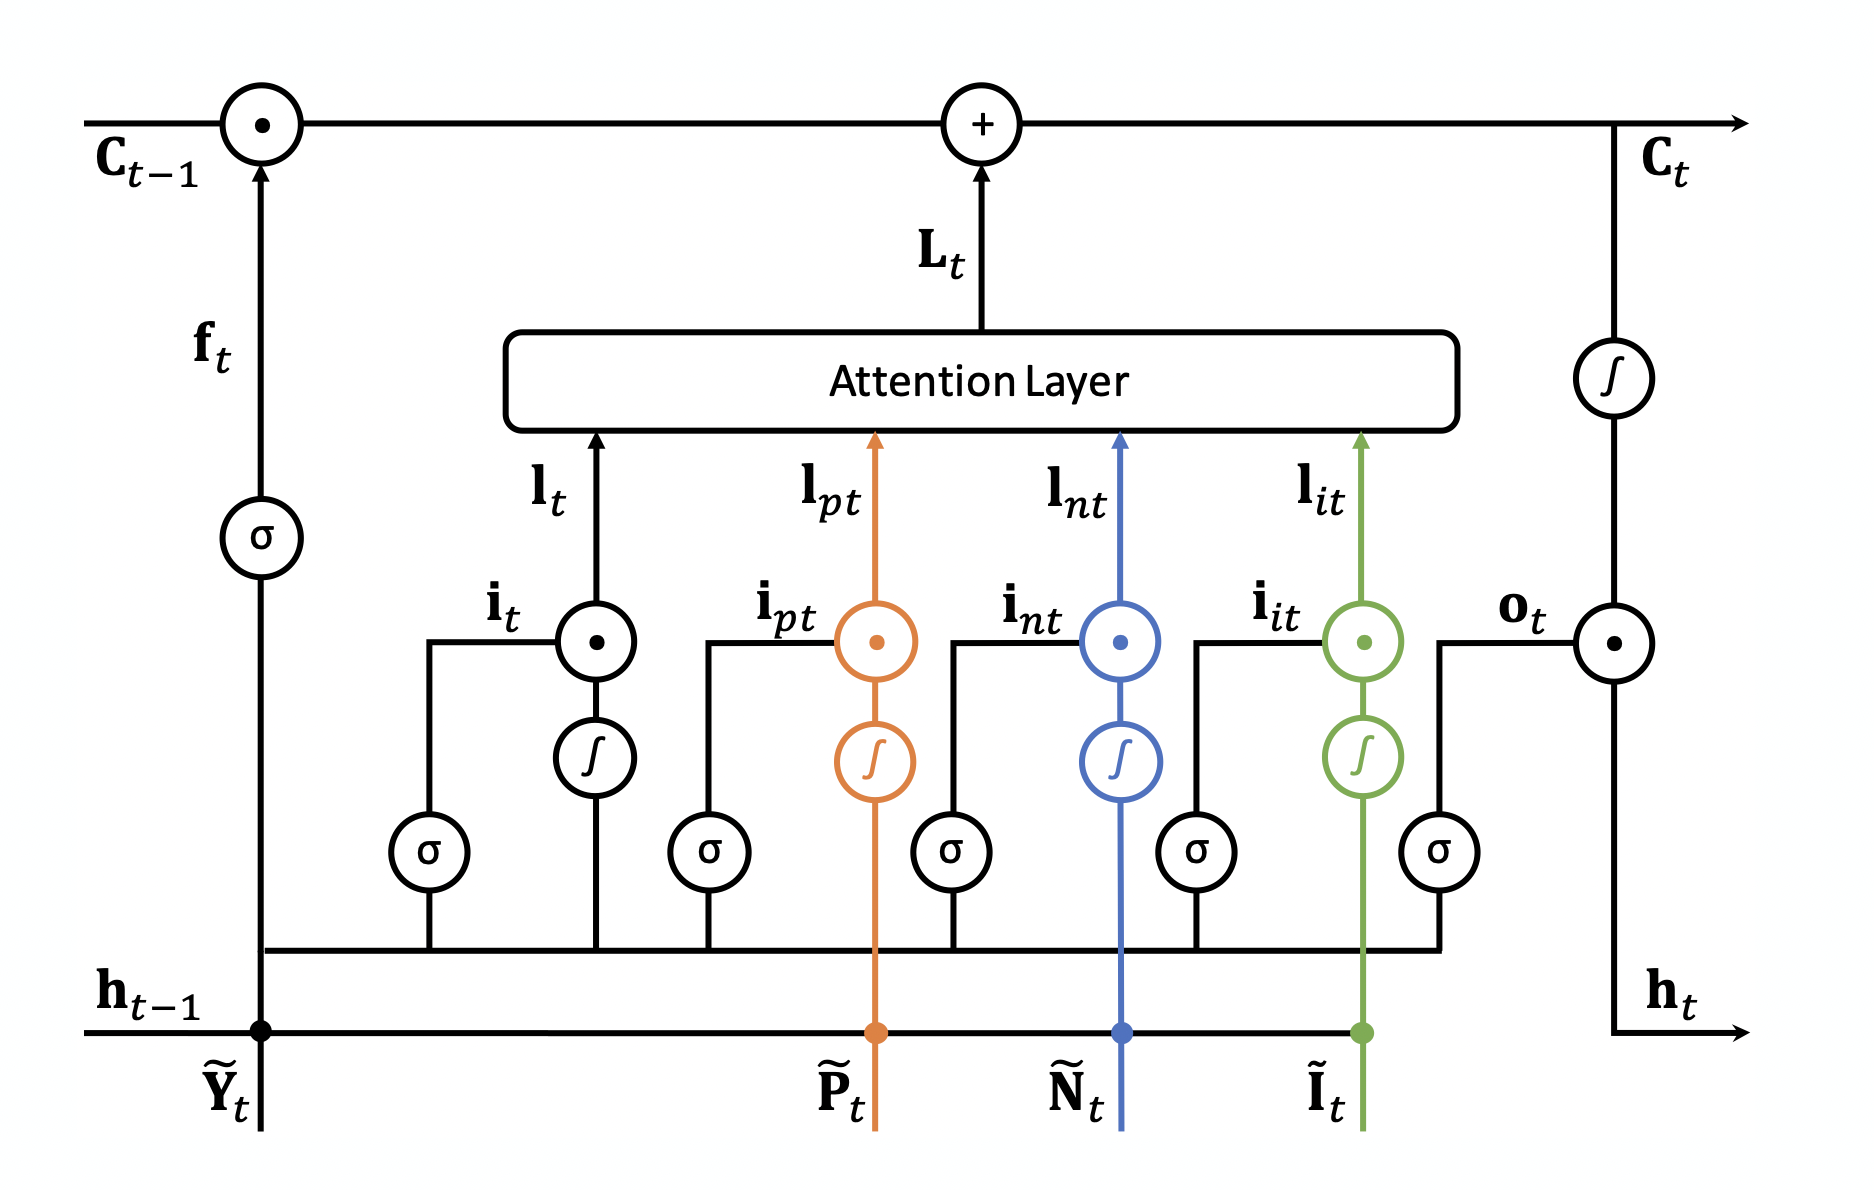

In [12]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()

        self.W_b = nn.Linear(hidden_size, hidden_size)
        nn.init.xavier_normal_(self.W_b.weight)

        self.v_b = nn.Parameter(torch.nn.init.xavier_normal_(torch.zeros(1, hidden_size)))

    def forward(self, Y_tag):

        j = torch.tanh(self.W_b(Y_tag)) @ self.v_b.T
        return F.softmax(j, dim=1)

In [13]:
class MI_Cell(nn.Module):
    def __init__(self , input_size, hidden_size):
        super(MI_Cell, self).__init__()
        self.hidden_dim = hidden_size

        self.W_f = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_f.weight)

        self.W_o = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_o.weight)

        self.W_c = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_c.weight)

        # init with zero for filter auxilary data from related stocks w/o being biased
        self.W_cp = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.zeros_(self.W_cp.weight)
        nn.init.zeros_(self.W_cp.bias)

        # init with zero for filter auxilary data from related stocks w/o being biased
        self.W_cn = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.zeros_(self.W_cn.weight)
        nn.init.zeros_(self.W_cn.bias)
        
        # init with zero for filter auxilary data from related stocks w/o being biased
        self.W_ci = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.zeros_(self.W_ci.weight)
        nn.init.zeros_(self.W_ci.bias)

        self.W_i = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_i.weight)

        self.W_ip = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_ip.weight)

        self.W_in = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_in.weight)

        self.W_ii = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_ii.weight)

        self.W_a = nn.Linear(hidden_size, hidden_size)
        nn.init.xavier_normal_(self.W_a.weight)


    def forward(self, x, p, n, i, c_t_prev, h_t_prev):

        Y_tag = torch.zeros(x.size(0), 0, self.hidden_dim).to(device)

        for t in range(x.size(1)):

            x_t = torch.cat((h_t_prev, x[:, t].unsqueeze(2)), dim=1).view(x.size(0), 1, -1)
            p_t = torch.cat((h_t_prev, p[:, t].unsqueeze(2)), dim=1).view(p.size(0), 1, -1)
            n_t = torch.cat((h_t_prev, n[:, t].unsqueeze(2)), dim=1).view(n.size(0), 1, -1)
            i_t = torch.cat((h_t_prev, i[:, t].unsqueeze(2)), dim=1).view(i.size(0), 1, -1)

            f_t = torch.sigmoid(self.W_f(x_t))
            L_t, α = self.input_gate(x_t, p_t, n_t, i_t , c_t_prev)
            o_t = torch.sigmoid(self.W_o(x_t))

            c_t = c_t_prev * f_t + L_t
            h_t = torch.tanh(c_t * o_t)

            Y_tag = torch.cat((Y_tag, h_t), dim=1)

            h_t_prev = torch.transpose(h_t, 1, 2)
            c_t_prev = c_t
        # returns the output and the attention weights
        return Y_tag, α


    def input_gate(self, x, p, n, i, c_t_prev):

        c_t = torch.tanh(self.W_c(x))
        c_pt = torch.tanh(self.W_cp(p))
        c_nt = torch.tanh(self.W_cn(n))
        c_it = torch.tanh(self.W_ci(i))
        i_t = torch.sigmoid(self.W_i(x))

        i_pt = torch.sigmoid(self.W_ip(x))
        i_nt = torch.sigmoid(self.W_in(x))
        i_it = torch.sigmoid(self.W_ii(x))

        I_t = c_t * i_t
        I_pt = c_pt * i_pt
        I_nt = c_nt * i_nt
        I_it = c_it * i_it

        u_t = torch.tanh((self.W_a(c_t_prev) @ torch.transpose(I_t, 1, 2)))
        u_pt = torch.tanh((self.W_a(c_t_prev) @ torch.transpose(I_pt, 1, 2)))
        u_nt = torch.tanh((self.W_a(c_t_prev) @ torch.transpose(I_nt, 1, 2)))
        u_it = torch.tanh((self.W_a(c_t_prev) @ torch.transpose(I_it, 1, 2)))

        α = F.softmax(torch.cat((u_t, u_it, u_nt, u_pt), dim=1), dim=1)
        α_t, α_pt, α_nt, α_it = α[:,0].unsqueeze(2), α[:,1].unsqueeze(2), α[:,2].unsqueeze(2), α[:,3].unsqueeze(2)

        return [α_t * I_t + I_pt * α_pt + I_nt * α_nt + I_it * α_it, α]


In [14]:
class LSTMLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super(LSTMLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        return out


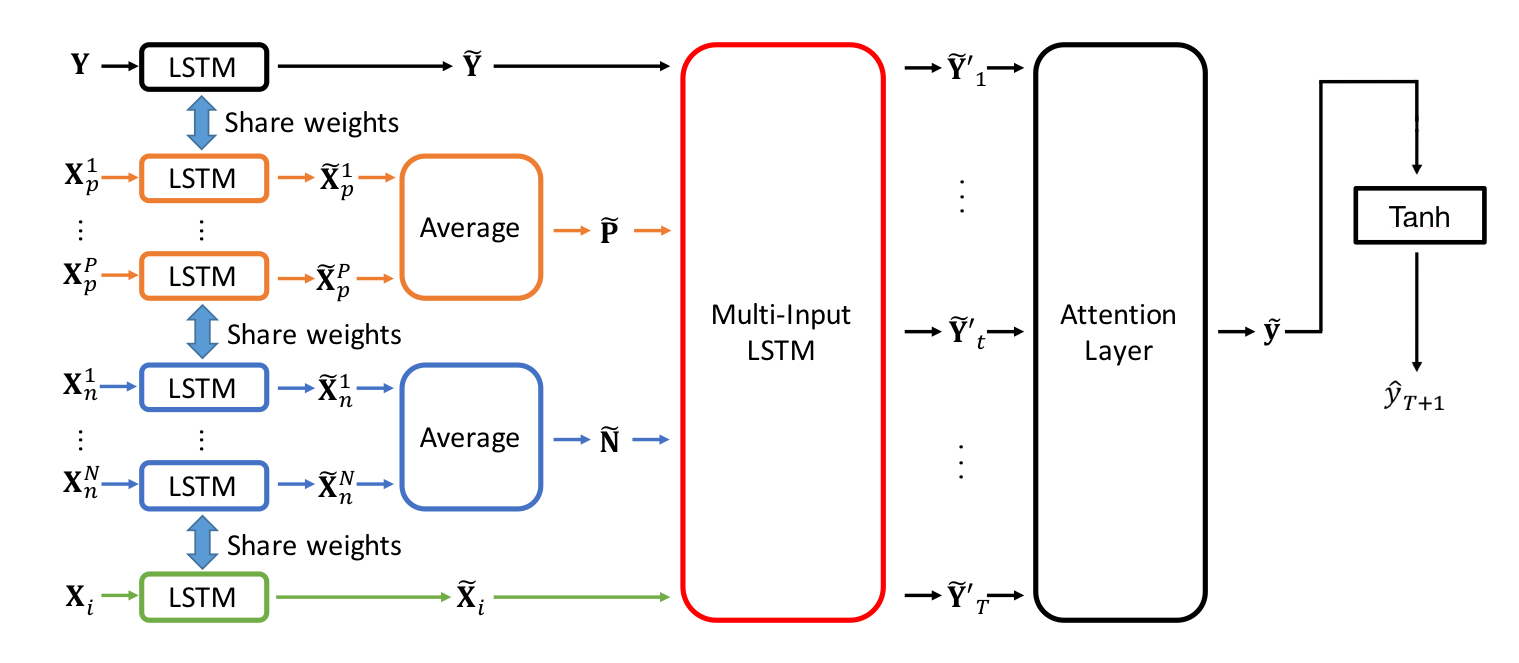

In [15]:
class MI_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MI_LSTM, self).__init__()

        self.hidden_dim = hidden_size

        self.lstm = LSTMLayer(1, hidden_size, 1)
        self.multi_input_lstm = MI_Cell(hidden_size, hidden_size)
        self.attention_layer = AttentionLayer(hidden_size)

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        nn.init.xavier_normal_(self.fc1.weight)

        self.fc2 = nn.Linear(hidden_size, output_size)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x, p, n, i):
        c_t_prev = torch.zeros(x.size(0), 1, self.hidden_dim).requires_grad_().to(device)
        h_t_prev = torch.zeros(x.size(0), self.hidden_dim, 1).requires_grad_().to(device)

        Y_input = self.lstm(x)
        P_input = self.train_pos_neg_avg(p, size=Y_input.size())
        N_input = self.train_pos_neg_avg(n, size=Y_input.size())
        I_input = self.lstm(i)

        Y_tag, α = self.multi_input_lstm(Y_input, P_input, N_input, I_input, c_t_prev, h_t_prev)

        β = self.attention_layer(Y_tag)
        y_tilda = torch.transpose(β,1 ,2) @ Y_tag

        fc1 = torch.tanh(self.fc1(y_tilda))
        y_t_next = self.fc2(fc1)
        return y_t_next.squeeze(dim=2), α

    def train_pos_neg_avg(self, related_stocks, size):
        avg = torch.zeros(size).to(device)
        for company in related_stocks:
            avg += self.lstm(company)

        return avg / related_stocks.size(0)

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) # last output
        return out

In [17]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, _ = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Functions

In [18]:
def split_data(stock, window_size, rate):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for i in range(len(data_raw) - window_size):
        data.append(data_raw[i: i + window_size])

    data = np.array(data)
    test_set_size = int(np.floor(rate * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1]

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)

    return [x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)]


In [19]:
def train(x_train, y_train, model, criterion, optimizer, epochs, device):

    epoch_loss = []
    for epoch in range(epochs):

        batches_loss = 0.
        for i, (inputs, labels) in enumerate(zip(x_train, y_train)):

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            batches_loss += loss.item()
            # if i % 25 == 0:
                # print(f'epoch: {epoch+1}/{epochs}, batch_loss: {loss.item():.5f}')
        # print(f'epoch: {epoch+1}\{epochs}, loss: {loss.item()}')

        epoch_loss.append(batches_loss)
        # print(f'company: {comp} epoch: {epoch+1}/{epochs}, epoch loss: {epoch_loss[-1]}')

    return epoch_loss

In [21]:
def train_MI(x, y, pos, neg, idx,
         model, criterion, optimizer, epochs, device):
    epoch_loss = []
    epoch_attentions = torch.zeros(0, x.size(0) * x.size(1), 4, 1).to(device)
    for epoch in range(epochs):
        attention_weights = torch.zeros(0, 4, 1).to(device)
        running_loss = 0.
        for i in range(x.size(0)):

            labels = y[i]

            optimizer.zero_grad()

            outputs, α = model(x[i], pos[:, i], neg[:, i], idx[i])
            attention_weights = torch.cat((attention_weights, α), dim=0)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 0:
                print(f'epoch: {epoch+1}/{epochs}, batch: {i+1}/{x.size(0)}, loss: {running_loss/(i+1):.5f}')

        epoch_attentions = torch.cat((epoch_attentions, attention_weights.unsqueeze(dim=0)))
        epoch_loss.append(running_loss)

    return epoch_loss, epoch_attentions


# Implementation

Company: CCL
Chosen number of highly correlated companies: 5


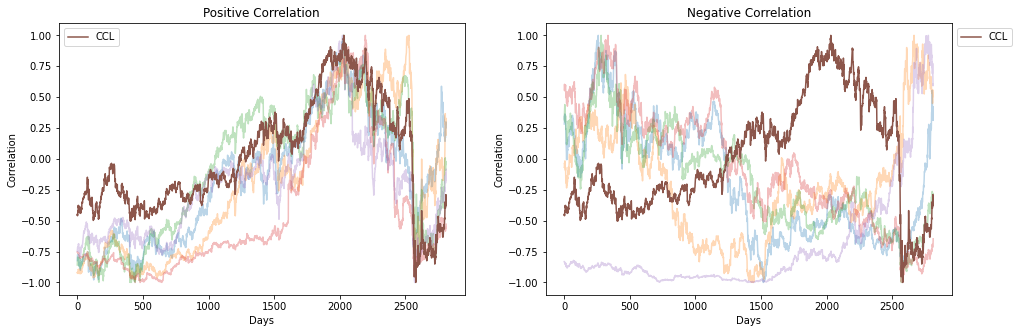

epoch: 1/20, batch: 1/37, loss: 0.10752
epoch: 1/20, batch: 11/37, loss: 0.03524
epoch: 1/20, batch: 21/37, loss: 0.02485
epoch: 1/20, batch: 31/37, loss: 0.03385
epoch: 2/20, batch: 1/37, loss: 0.51197
epoch: 2/20, batch: 11/37, loss: 0.11929
epoch: 2/20, batch: 21/37, loss: 0.06655
epoch: 2/20, batch: 31/37, loss: 0.05874
epoch: 3/20, batch: 1/37, loss: 0.16436
epoch: 3/20, batch: 11/37, loss: 0.03165
epoch: 3/20, batch: 21/37, loss: 0.01832
epoch: 3/20, batch: 31/37, loss: 0.01498
epoch: 4/20, batch: 1/37, loss: 0.00407
epoch: 4/20, batch: 11/37, loss: 0.00656
epoch: 4/20, batch: 21/37, loss: 0.00498
epoch: 4/20, batch: 31/37, loss: 0.00550
epoch: 5/20, batch: 1/37, loss: 0.03657
epoch: 5/20, batch: 11/37, loss: 0.01071
epoch: 5/20, batch: 21/37, loss: 0.00715
epoch: 5/20, batch: 31/37, loss: 0.00688
epoch: 6/20, batch: 1/37, loss: 0.03801
epoch: 6/20, batch: 11/37, loss: 0.01004
epoch: 6/20, batch: 21/37, loss: 0.00677
epoch: 6/20, batch: 31/37, loss: 0.00648
epoch: 7/20, batch: 1/

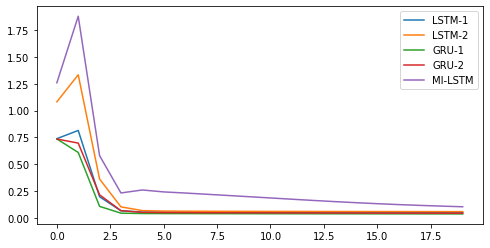

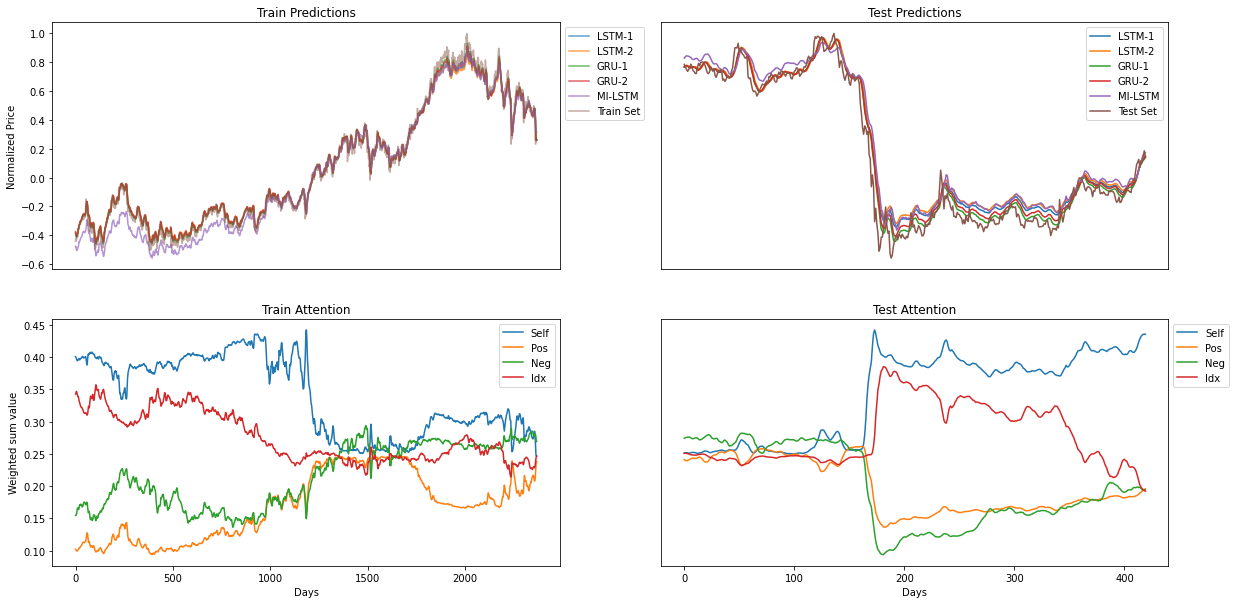

Company: AAPL
Chosen number of highly correlated companies: 5


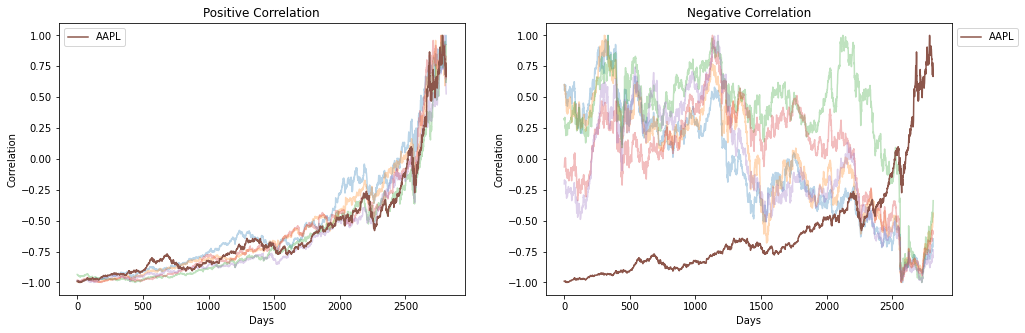

epoch: 1/20, batch: 1/37, loss: 0.73489
epoch: 1/20, batch: 11/37, loss: 0.23941
epoch: 1/20, batch: 21/37, loss: 0.12671
epoch: 1/20, batch: 31/37, loss: 0.08755
epoch: 2/20, batch: 1/37, loss: 0.20917
epoch: 2/20, batch: 11/37, loss: 0.04650
epoch: 2/20, batch: 21/37, loss: 0.02581
epoch: 2/20, batch: 31/37, loss: 0.01926
epoch: 3/20, batch: 1/37, loss: 0.18975
epoch: 3/20, batch: 11/37, loss: 0.04118
epoch: 3/20, batch: 21/37, loss: 0.02297
epoch: 3/20, batch: 31/37, loss: 0.01720
epoch: 4/20, batch: 1/37, loss: 0.17141
epoch: 4/20, batch: 11/37, loss: 0.03482
epoch: 4/20, batch: 21/37, loss: 0.01948
epoch: 4/20, batch: 31/37, loss: 0.01460
epoch: 5/20, batch: 1/37, loss: 0.15019
epoch: 5/20, batch: 11/37, loss: 0.02711
epoch: 5/20, batch: 21/37, loss: 0.01523
epoch: 5/20, batch: 31/37, loss: 0.01143
epoch: 6/20, batch: 1/37, loss: 0.12222
epoch: 6/20, batch: 11/37, loss: 0.01849
epoch: 6/20, batch: 21/37, loss: 0.01050
epoch: 6/20, batch: 31/37, loss: 0.00791
epoch: 7/20, batch: 1/

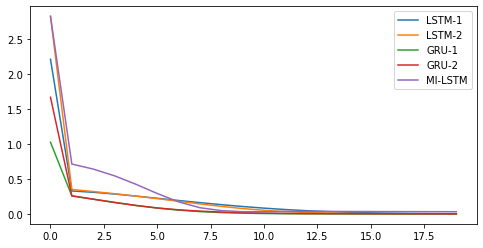

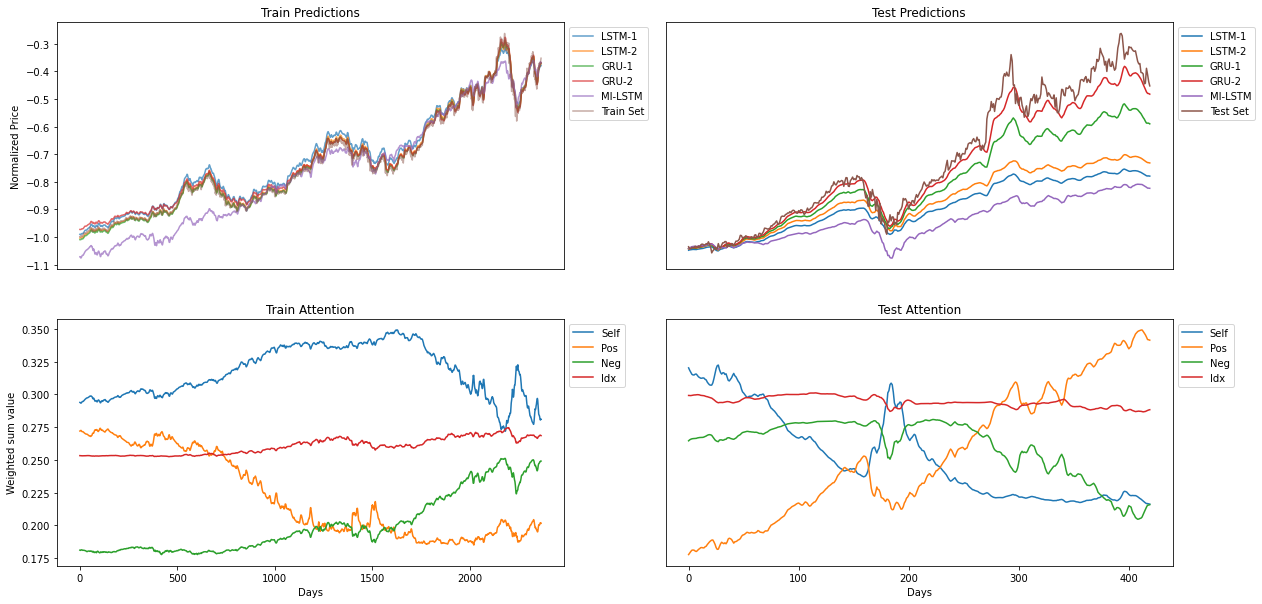

Company: GOOG
Chosen number of highly correlated companies: 5


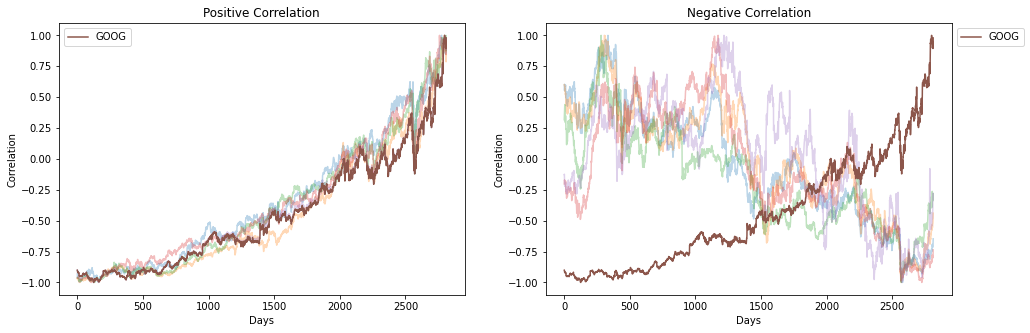

epoch: 1/20, batch: 1/37, loss: 0.76397
epoch: 1/20, batch: 11/37, loss: 0.19064
epoch: 1/20, batch: 21/37, loss: 0.10134
epoch: 1/20, batch: 31/37, loss: 0.07479
epoch: 2/20, batch: 1/37, loss: 0.51263
epoch: 2/20, batch: 11/37, loss: 0.12553
epoch: 2/20, batch: 21/37, loss: 0.06682
epoch: 2/20, batch: 31/37, loss: 0.04979
epoch: 3/20, batch: 1/37, loss: 0.37336
epoch: 3/20, batch: 11/37, loss: 0.06525
epoch: 3/20, batch: 21/37, loss: 0.03478
epoch: 3/20, batch: 31/37, loss: 0.02520
epoch: 4/20, batch: 1/37, loss: 0.14941
epoch: 4/20, batch: 11/37, loss: 0.01699
epoch: 4/20, batch: 21/37, loss: 0.00940
epoch: 4/20, batch: 31/37, loss: 0.00674
epoch: 5/20, batch: 1/37, loss: 0.00773
epoch: 5/20, batch: 11/37, loss: 0.00113
epoch: 5/20, batch: 21/37, loss: 0.00108
epoch: 5/20, batch: 31/37, loss: 0.00097
epoch: 6/20, batch: 1/37, loss: 0.00217
epoch: 6/20, batch: 11/37, loss: 0.00137
epoch: 6/20, batch: 21/37, loss: 0.00122
epoch: 6/20, batch: 31/37, loss: 0.00105
epoch: 7/20, batch: 1/

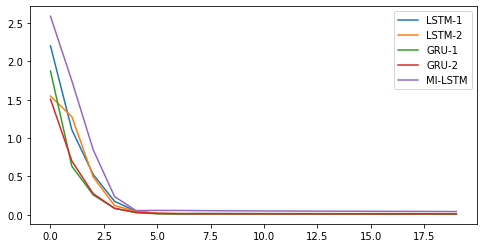

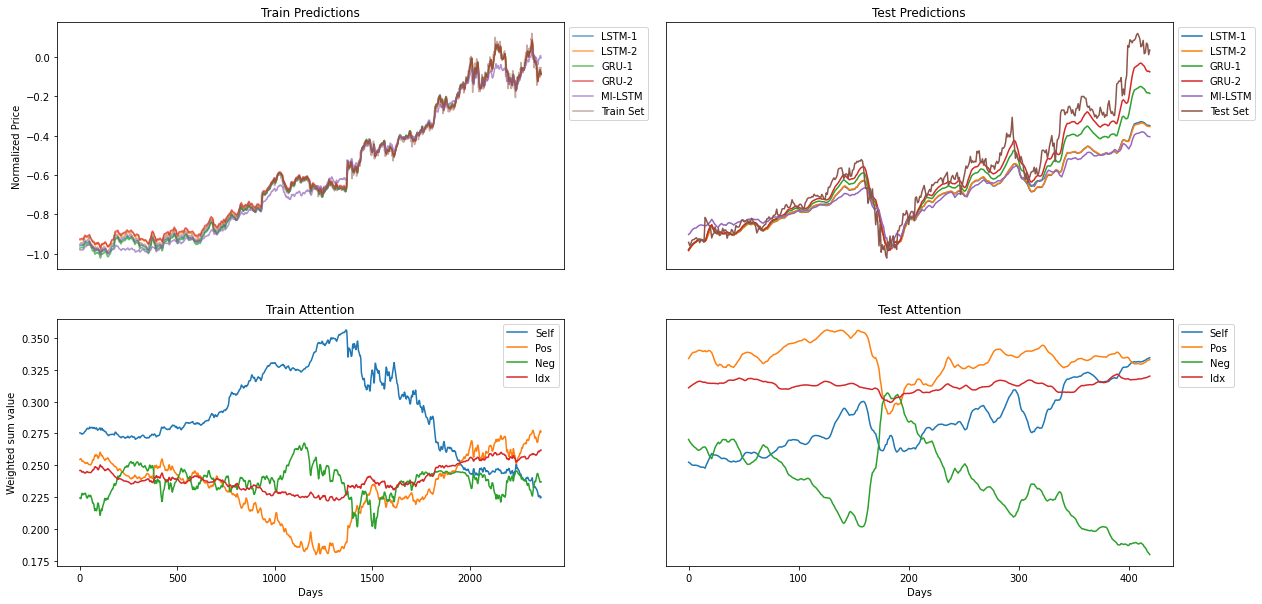

Company: NFLX
Chosen number of highly correlated companies: 5


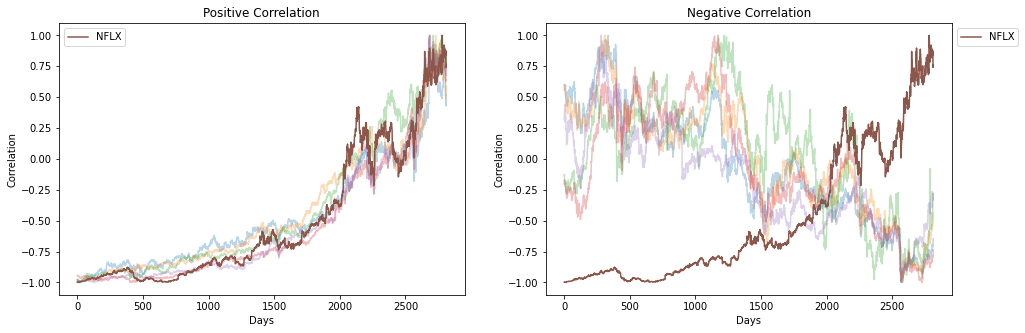

epoch: 1/20, batch: 1/37, loss: 1.60241
epoch: 1/20, batch: 11/37, loss: 0.49037
epoch: 1/20, batch: 21/37, loss: 0.25732
epoch: 1/20, batch: 31/37, loss: 0.17699
epoch: 2/20, batch: 1/37, loss: 0.55536
epoch: 2/20, batch: 11/37, loss: 0.10943
epoch: 2/20, batch: 21/37, loss: 0.05762
epoch: 2/20, batch: 31/37, loss: 0.04054
epoch: 3/20, batch: 1/37, loss: 0.36894
epoch: 3/20, batch: 11/37, loss: 0.05007
epoch: 3/20, batch: 21/37, loss: 0.02644
epoch: 3/20, batch: 31/37, loss: 0.01835
epoch: 4/20, batch: 1/37, loss: 0.11426
epoch: 4/20, batch: 11/37, loss: 0.01076
epoch: 4/20, batch: 21/37, loss: 0.00591
epoch: 4/20, batch: 31/37, loss: 0.00426
epoch: 5/20, batch: 1/37, loss: 0.02235
epoch: 5/20, batch: 11/37, loss: 0.00889
epoch: 5/20, batch: 21/37, loss: 0.00494
epoch: 5/20, batch: 31/37, loss: 0.00375
epoch: 6/20, batch: 1/37, loss: 0.18629
epoch: 6/20, batch: 11/37, loss: 0.03449
epoch: 6/20, batch: 21/37, loss: 0.01839
epoch: 6/20, batch: 31/37, loss: 0.01290
epoch: 7/20, batch: 1/

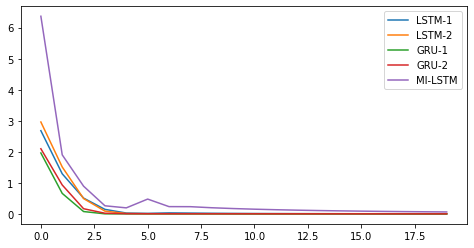

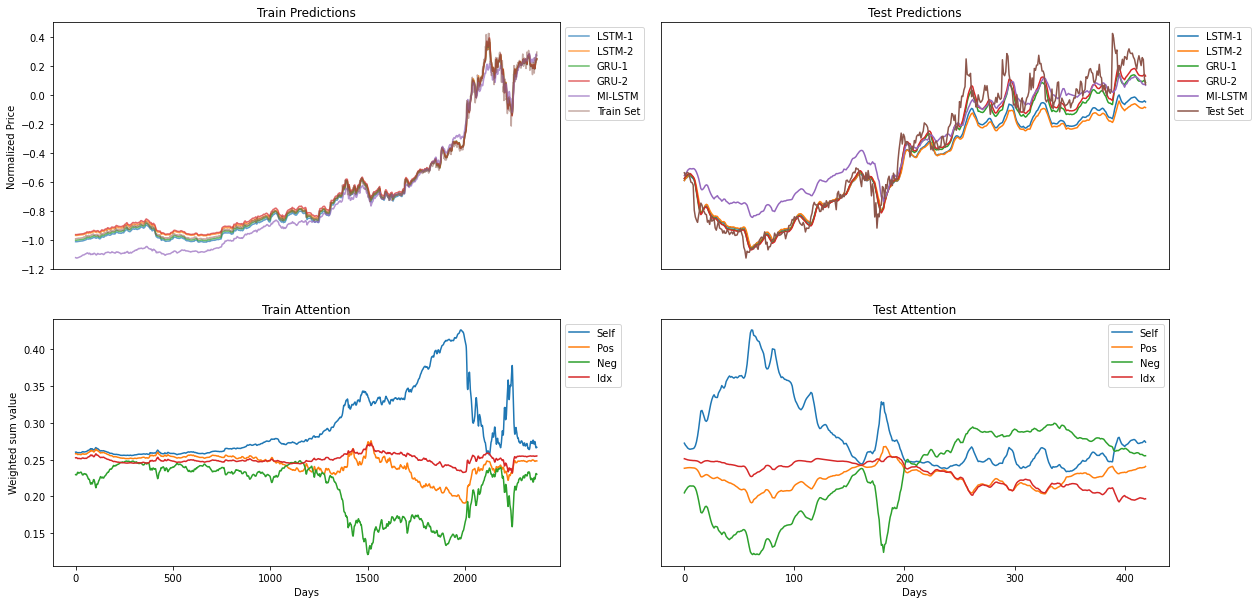

Company: AMZN
Chosen number of highly correlated companies: 5


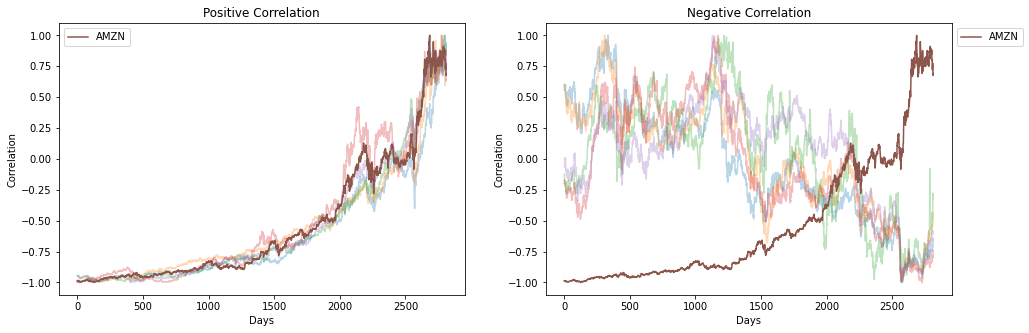

epoch: 1/20, batch: 1/37, loss: 0.94839
epoch: 1/20, batch: 11/37, loss: 0.29938
epoch: 1/20, batch: 21/37, loss: 0.15705
epoch: 1/20, batch: 31/37, loss: 0.10906
epoch: 2/20, batch: 1/37, loss: 0.41486
epoch: 2/20, batch: 11/37, loss: 0.10098
epoch: 2/20, batch: 21/37, loss: 0.05306
epoch: 2/20, batch: 31/37, loss: 0.03781
epoch: 3/20, batch: 1/37, loss: 0.32570
epoch: 3/20, batch: 11/37, loss: 0.05712
epoch: 3/20, batch: 21/37, loss: 0.03005
epoch: 3/20, batch: 31/37, loss: 0.02099
epoch: 4/20, batch: 1/37, loss: 0.17485
epoch: 4/20, batch: 11/37, loss: 0.01906
epoch: 4/20, batch: 21/37, loss: 0.01019
epoch: 4/20, batch: 31/37, loss: 0.00705
epoch: 5/20, batch: 1/37, loss: 0.00646
epoch: 5/20, batch: 11/37, loss: 0.00299
epoch: 5/20, batch: 21/37, loss: 0.00186
epoch: 5/20, batch: 31/37, loss: 0.00148
epoch: 6/20, batch: 1/37, loss: 0.04485
epoch: 6/20, batch: 11/37, loss: 0.00869
epoch: 6/20, batch: 21/37, loss: 0.00490
epoch: 6/20, batch: 31/37, loss: 0.00358
epoch: 7/20, batch: 1/

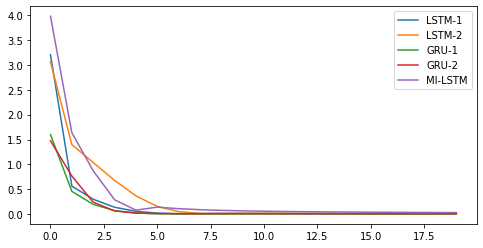

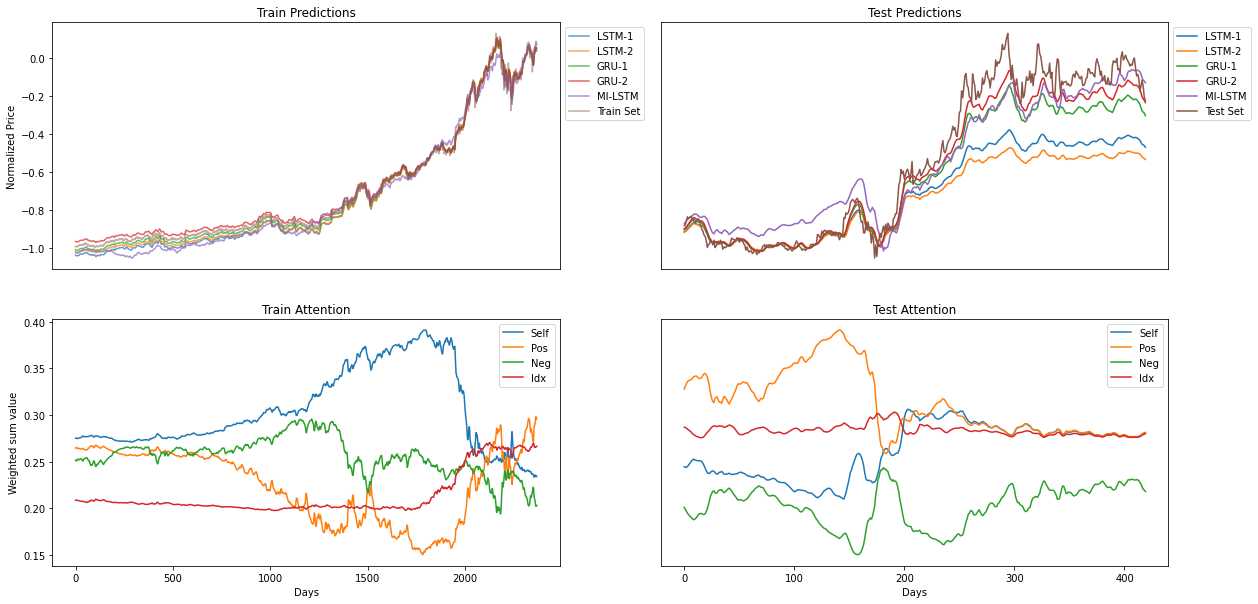

Company: MGM
Chosen number of highly correlated companies: 5


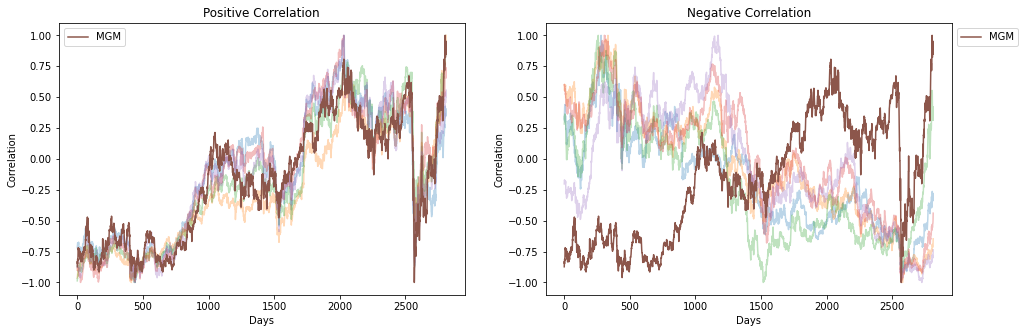

epoch: 1/20, batch: 1/37, loss: 0.82116
epoch: 1/20, batch: 11/37, loss: 0.16042
epoch: 1/20, batch: 21/37, loss: 0.09859
epoch: 1/20, batch: 31/37, loss: 0.08233
epoch: 2/20, batch: 1/37, loss: 0.54468
epoch: 2/20, batch: 11/37, loss: 0.10954
epoch: 2/20, batch: 21/37, loss: 0.06670
epoch: 2/20, batch: 31/37, loss: 0.05183
epoch: 3/20, batch: 1/37, loss: 0.15258
epoch: 3/20, batch: 11/37, loss: 0.02130
epoch: 3/20, batch: 21/37, loss: 0.01643
epoch: 3/20, batch: 31/37, loss: 0.01405
epoch: 4/20, batch: 1/37, loss: 0.01674
epoch: 4/20, batch: 11/37, loss: 0.00478
epoch: 4/20, batch: 21/37, loss: 0.00674
epoch: 4/20, batch: 31/37, loss: 0.00695
epoch: 5/20, batch: 1/37, loss: 0.00287
epoch: 5/20, batch: 11/37, loss: 0.00299
epoch: 5/20, batch: 21/37, loss: 0.00543
epoch: 5/20, batch: 31/37, loss: 0.00590
epoch: 6/20, batch: 1/37, loss: 0.00287
epoch: 6/20, batch: 11/37, loss: 0.00299
epoch: 6/20, batch: 21/37, loss: 0.00514
epoch: 6/20, batch: 31/37, loss: 0.00558
epoch: 7/20, batch: 1/

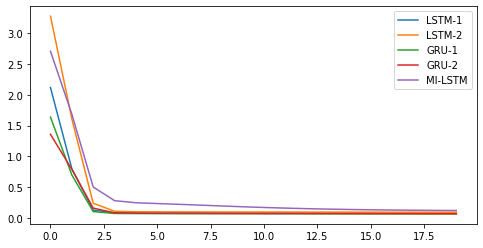

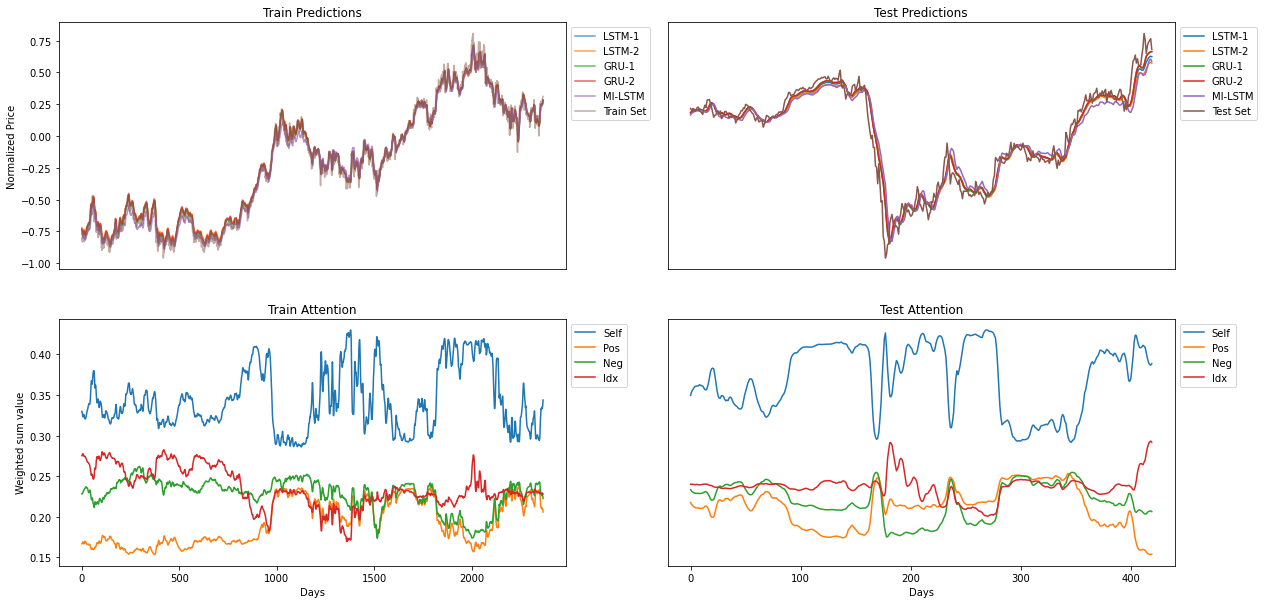

Company: CVX
Chosen number of highly correlated companies: 5


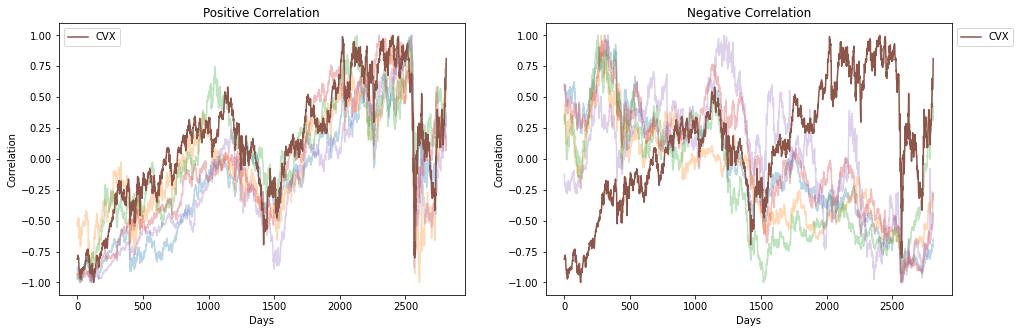

epoch: 1/20, batch: 1/37, loss: 0.67914
epoch: 1/20, batch: 11/37, loss: 0.11675
epoch: 1/20, batch: 21/37, loss: 0.08012
epoch: 1/20, batch: 31/37, loss: 0.07892
epoch: 2/20, batch: 1/37, loss: 1.30813
epoch: 2/20, batch: 11/37, loss: 0.22283
epoch: 2/20, batch: 21/37, loss: 0.12555
epoch: 2/20, batch: 31/37, loss: 0.09456
epoch: 3/20, batch: 1/37, loss: 0.32014
epoch: 3/20, batch: 11/37, loss: 0.03903
epoch: 3/20, batch: 21/37, loss: 0.02234
epoch: 3/20, batch: 31/37, loss: 0.01769
epoch: 4/20, batch: 1/37, loss: 0.01347
epoch: 4/20, batch: 11/37, loss: 0.00484
epoch: 4/20, batch: 21/37, loss: 0.00442
epoch: 4/20, batch: 31/37, loss: 0.00546
epoch: 5/20, batch: 1/37, loss: 0.01139
epoch: 5/20, batch: 11/37, loss: 0.00427
epoch: 5/20, batch: 21/37, loss: 0.00399
epoch: 5/20, batch: 31/37, loss: 0.00487
epoch: 6/20, batch: 1/37, loss: 0.00634
epoch: 6/20, batch: 11/37, loss: 0.00353
epoch: 6/20, batch: 21/37, loss: 0.00352
epoch: 6/20, batch: 31/37, loss: 0.00437
epoch: 7/20, batch: 1/

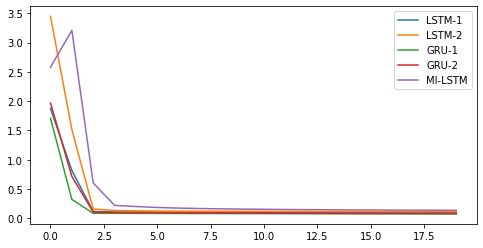

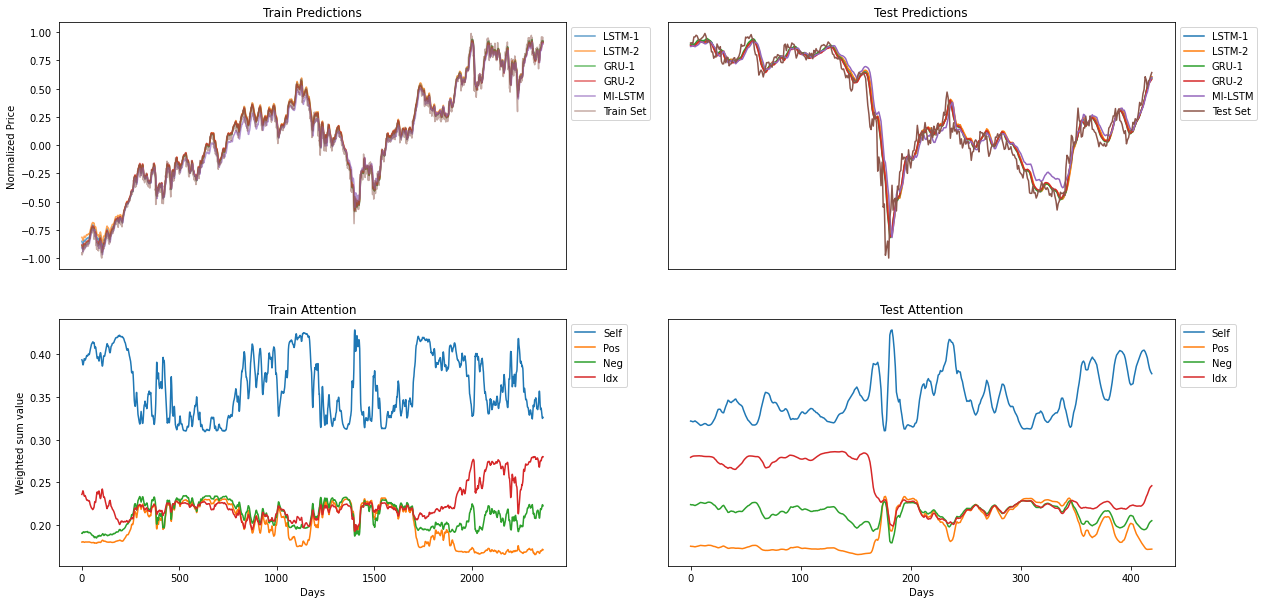

Company: BAC
Chosen number of highly correlated companies: 5


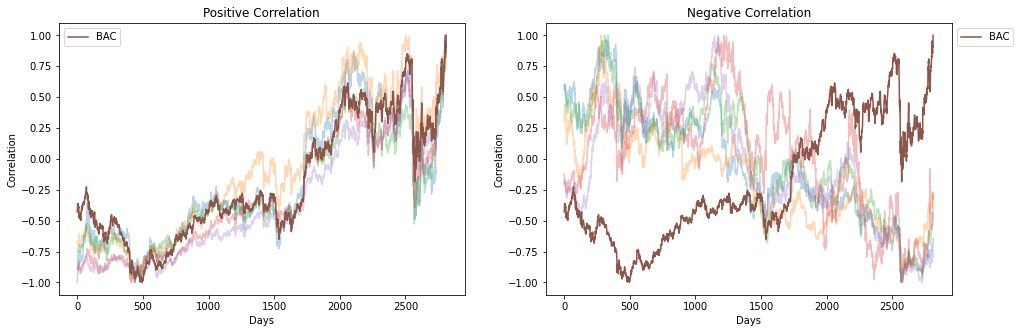

epoch: 1/20, batch: 1/37, loss: 0.07299
epoch: 1/20, batch: 11/37, loss: 0.03267
epoch: 1/20, batch: 21/37, loss: 0.01970
epoch: 1/20, batch: 31/37, loss: 0.02869
epoch: 2/20, batch: 1/37, loss: 0.34740
epoch: 2/20, batch: 11/37, loss: 0.12955
epoch: 2/20, batch: 21/37, loss: 0.06988
epoch: 2/20, batch: 31/37, loss: 0.05867
epoch: 3/20, batch: 1/37, loss: 0.02641
epoch: 3/20, batch: 11/37, loss: 0.01141
epoch: 3/20, batch: 21/37, loss: 0.00658
epoch: 3/20, batch: 31/37, loss: 0.00589
epoch: 4/20, batch: 1/37, loss: 0.08010
epoch: 4/20, batch: 11/37, loss: 0.01187
epoch: 4/20, batch: 21/37, loss: 0.00680
epoch: 4/20, batch: 31/37, loss: 0.00582
epoch: 5/20, batch: 1/37, loss: 0.09884
epoch: 5/20, batch: 11/37, loss: 0.01307
epoch: 5/20, batch: 21/37, loss: 0.00741
epoch: 5/20, batch: 31/37, loss: 0.00617
epoch: 6/20, batch: 1/37, loss: 0.09716
epoch: 6/20, batch: 11/37, loss: 0.01232
epoch: 6/20, batch: 21/37, loss: 0.00699
epoch: 6/20, batch: 31/37, loss: 0.00581
epoch: 7/20, batch: 1/

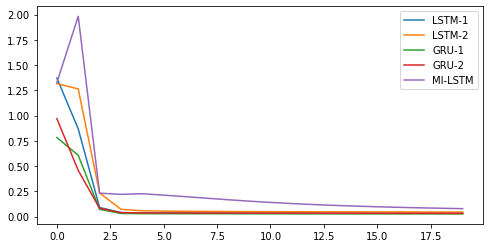

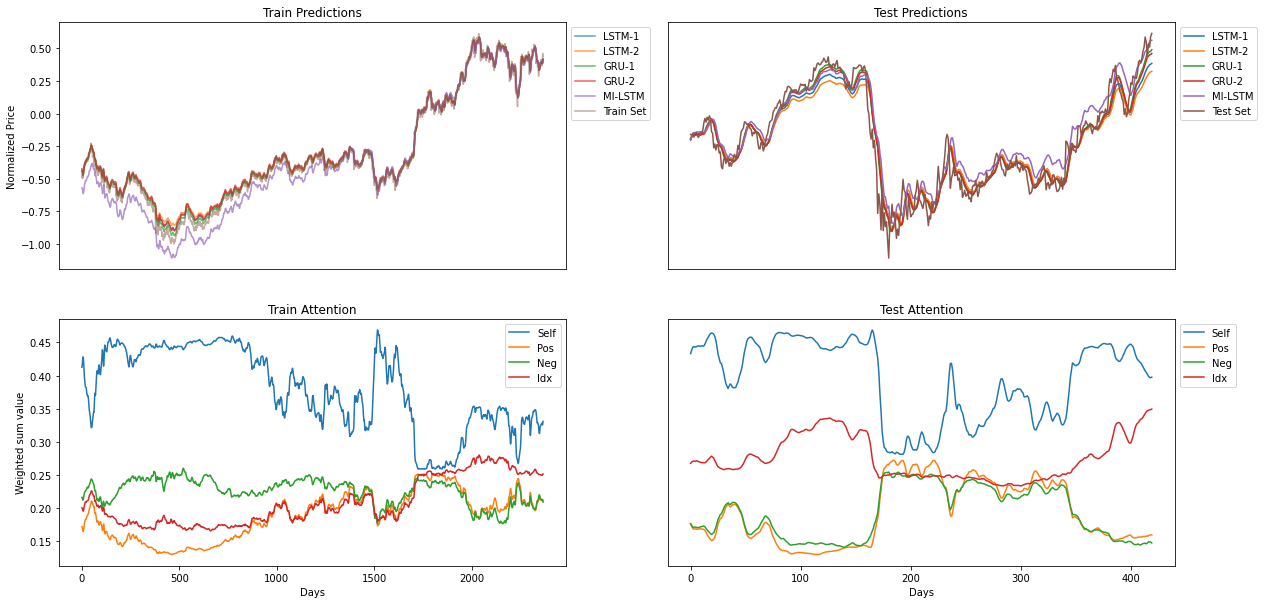

Company: BA
Chosen number of highly correlated companies: 5


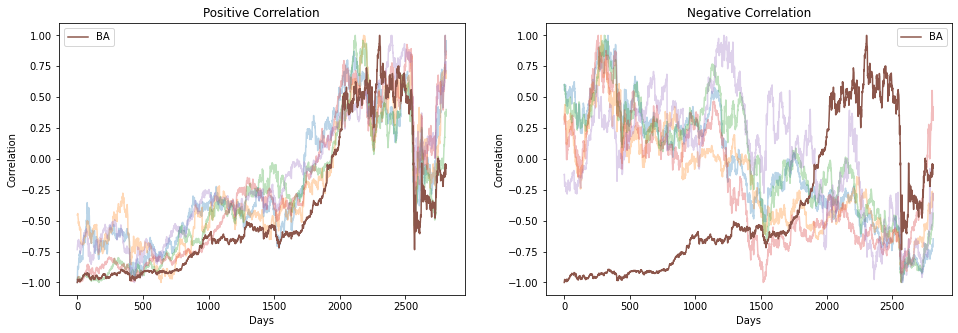

epoch: 1/20, batch: 1/37, loss: 1.01139
epoch: 1/20, batch: 11/37, loss: 0.51408
epoch: 1/20, batch: 21/37, loss: 0.27235
epoch: 1/20, batch: 31/37, loss: 0.20100
epoch: 2/20, batch: 1/37, loss: 0.62812
epoch: 2/20, batch: 11/37, loss: 0.22770
epoch: 2/20, batch: 21/37, loss: 0.12053
epoch: 2/20, batch: 31/37, loss: 0.09177
epoch: 3/20, batch: 1/37, loss: 0.48630
epoch: 3/20, batch: 11/37, loss: 0.08661
epoch: 3/20, batch: 21/37, loss: 0.04567
epoch: 3/20, batch: 31/37, loss: 0.03335
epoch: 4/20, batch: 1/37, loss: 0.07306
epoch: 4/20, batch: 11/37, loss: 0.00752
epoch: 4/20, batch: 21/37, loss: 0.00450
epoch: 4/20, batch: 31/37, loss: 0.00367
epoch: 5/20, batch: 1/37, loss: 0.31385
epoch: 5/20, batch: 11/37, loss: 0.04454
epoch: 5/20, batch: 21/37, loss: 0.02390
epoch: 5/20, batch: 31/37, loss: 0.01689
epoch: 6/20, batch: 1/37, loss: 0.14147
epoch: 6/20, batch: 11/37, loss: 0.01374
epoch: 6/20, batch: 21/37, loss: 0.00770
epoch: 6/20, batch: 31/37, loss: 0.00592
epoch: 7/20, batch: 1/

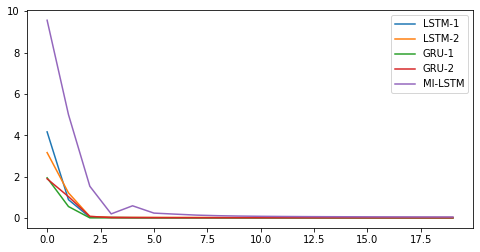

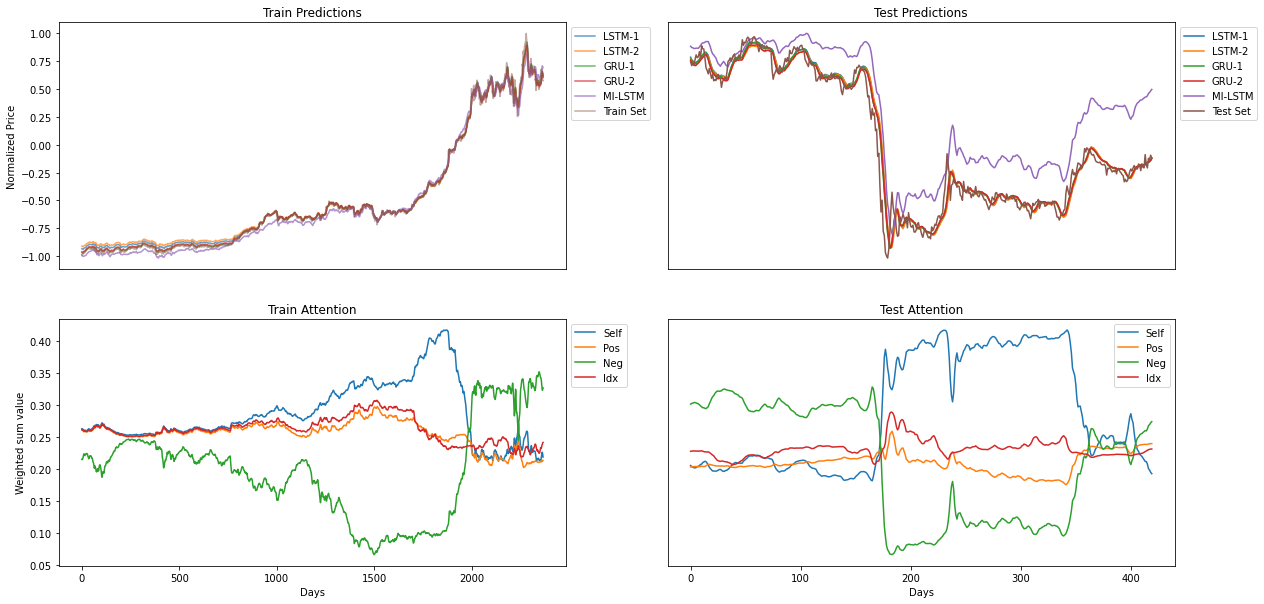

Company: DAL
Chosen number of highly correlated companies: 5


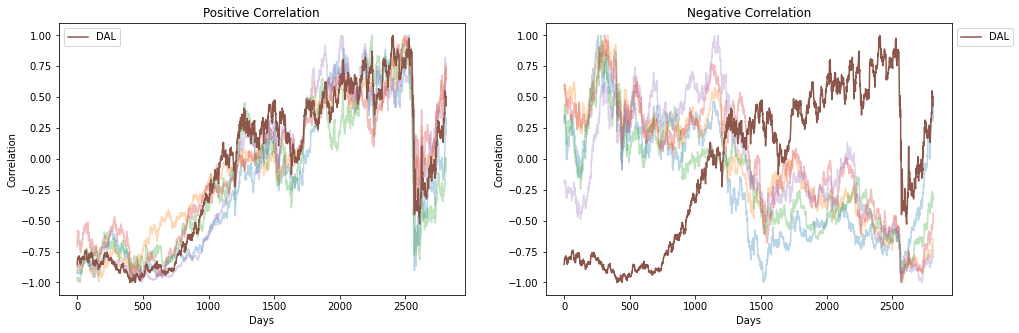

epoch: 1/20, batch: 1/37, loss: 0.69299
epoch: 1/20, batch: 11/37, loss: 0.11180
epoch: 1/20, batch: 21/37, loss: 0.08789
epoch: 1/20, batch: 31/37, loss: 0.06942
epoch: 2/20, batch: 1/37, loss: 1.28324
epoch: 2/20, batch: 11/37, loss: 0.25695
epoch: 2/20, batch: 21/37, loss: 0.14573
epoch: 2/20, batch: 31/37, loss: 0.10181
epoch: 3/20, batch: 1/37, loss: 0.24755
epoch: 3/20, batch: 11/37, loss: 0.02763
epoch: 3/20, batch: 21/37, loss: 0.01630
epoch: 3/20, batch: 31/37, loss: 0.01242
epoch: 4/20, batch: 1/37, loss: 0.00868
epoch: 4/20, batch: 11/37, loss: 0.00136
epoch: 4/20, batch: 21/37, loss: 0.00245
epoch: 4/20, batch: 31/37, loss: 0.00300
epoch: 5/20, batch: 1/37, loss: 0.00520
epoch: 5/20, batch: 11/37, loss: 0.00096
epoch: 5/20, batch: 21/37, loss: 0.00217
epoch: 5/20, batch: 31/37, loss: 0.00279
epoch: 6/20, batch: 1/37, loss: 0.00414
epoch: 6/20, batch: 11/37, loss: 0.00085
epoch: 6/20, batch: 21/37, loss: 0.00204
epoch: 6/20, batch: 31/37, loss: 0.00269
epoch: 7/20, batch: 1/

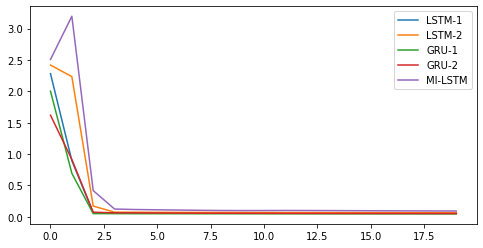

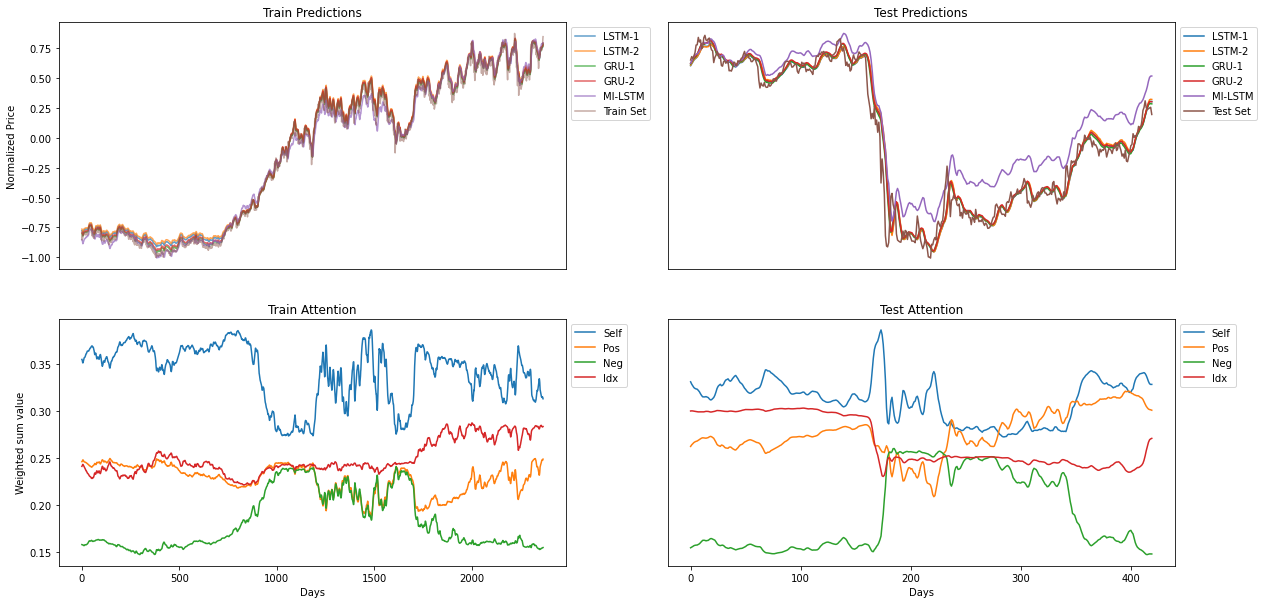

In [23]:
index = df_sp500 # normalized s&p500

for comp in comps: # for each company
    # split self and index to batches
    x = df_norm[comp] # normalized chosen company
    x_train, y_train, x_test, y_test = split_data(x, window_size, rate)
    # trunc the head for fixing the number of batches
    head_trunc = x_train.size(0) % batch_size

    x_train = x_train[head_trunc:]
    x_train = x_train.view(x_train.size(0) // batch_size, batch_size, -1, 1)

    y_train = y_train[head_trunc:]
    y_train = y_train.view(y_train.size(0) // batch_size, batch_size, 1)


    index_train, _, index_test, _ = split_data(index, window_size, rate)

    head_trunc = index_train.size(0) % batch_size

    index_train = index_train[head_trunc:]
    index_train = index_train.view(index_train.size(0) // batch_size, batch_size, -1, 1)

    # sort by correlation
    pearson = df_norm.corr(method='pearson')
    pearson = pearson.sort_values(by=comp)[comp]

    n_companies = 5 # fixed size of related companies
    print(f'Company: {comp}')
    print(f'Chosen number of highly correlated companies: {n_companies}')

    pos = pearson[-(n_companies+1):-1]
    pos = df_norm[pos.index.values]
    # Top negative correlated
    neg = pearson[:n_companies]
    neg = df_norm[neg.index.values]


    fig, ax = plt.subplots(1,2, figsize=(16, 5))

    for company_p in pos.columns.to_numpy():
        ax[0].plot(pos[company_p], alpha=0.3)
    ax[0].plot(df_norm[comp], alpha=1, label=comp)

    for company_n in neg.columns.to_numpy():
        ax[1].plot(neg[company_n], alpha=0.3)
    ax[1].plot(df_norm[comp], alpha=1, label=comp)

    ax[0].set(title='Positive Correlation', ylabel = 'Correlation', xlabel='Days')
    ax[0].legend()
    ax[1].set(title='Negative Correlation', ylabel = 'Correlation', xlabel='Days')
    ax[1].legend(bbox_to_anchor=(1, 1))
    plt.show()

    # LSTM 1 Layer
    model_lstm1 = LSTM(input_dim, hidden_dim, 1, output_dim).to(device)
    criterion_lstm1 = nn.MSELoss()
    optimizer_lstm1 = torch.optim.Adagrad(model_lstm1.parameters())

    train_lstm1 = train(x_train, y_train, model_lstm1, criterion_lstm1, optimizer_lstm1, epochs, device)

    with torch.no_grad():
        outputs_lstm_train1 = model_lstm1(x_train.view(-1, x_train.size(2), 1))
        lstm_train_MSE1 = criterion_lstm1(outputs_lstm_train1, y_train.view(-1,1))

        outputs_lstm_test1 = model_lstm1(x_test.view(-1, x_train.size(2), 1))
        lstm_test_MSE1 = criterion_lstm1(outputs_lstm_test1, y_test.view(-1,1))


    # LSTM 2 layers
    model_lstm = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
    criterion_lstm = nn.MSELoss()
    optimizer_lstm = torch.optim.Adagrad(model_lstm.parameters())

    train_lstm = train(x_train, y_train, model_lstm, criterion_lstm, optimizer_lstm, epochs, device)

    with torch.no_grad():
        outputs_lstm_train = model_lstm(x_train.view(-1, x_train.size(2), 1))
        lstm_train_MSE = criterion_lstm(outputs_lstm_train, y_train.view(-1,1))


        outputs_lstm_test = model_lstm(x_test.view(-1, x_train.size(2), 1))
        lstm_test_MSE = criterion_lstm(outputs_lstm_test, y_test.view(-1,1))


    # GRU 1 Layer
    model_gru1 = GRU(input_dim, hidden_dim, 1, output_dim).to(device)
    criterion_gru1 = nn.MSELoss()
    optimizer_gru1 = torch.optim.Adagrad(model_gru1.parameters())

    train_gru1 = train(x_train, y_train, model_gru1, criterion_gru1, optimizer_gru1, epochs, device)

    with torch.no_grad():
        outputs_gru_train1 = model_gru1(x_train.view(-1, x_train.size(2), 1))
        gru_train_MSE1 = criterion_gru1(outputs_gru_train1, y_train.view(-1,1))

        outputs_gru_test1 = model_gru1(x_test.view(-1, x_train.size(2), 1))
        gru_test_MSE1 = criterion_gru1(outputs_gru_test1, y_test.view(-1,1))


    # GRU 2 Layers
    model_gru = GRU(input_dim, hidden_dim, num_layers, output_dim).to(device)
    criterion_gru = nn.MSELoss()
    optimizer_gru = torch.optim.Adagrad(model_gru.parameters())

    train_gru = train(x_train, y_train, model_gru, criterion_gru, optimizer_gru, epochs, device)

    with torch.no_grad():
        outputs_gru_train = model_gru(x_train.view(-1, x_train.size(2), 1))
        gru_train_MSE = criterion_gru(outputs_gru_train, y_train.view(-1,1))

        outputs_gru_test = model_gru(x_test.view(-1, x_train.size(2), 1))
        gru_test_MSE = criterion_gru(outputs_gru_test, y_test.view(-1,1))


    # MI-LSTM
    # data processing for the positive anf negative correlated companies
    p_tensors_train = torch.zeros(0, x_train.size(0), x_train.size(1), x_train.size(2), 1).to(device)
    p_tensors_test = torch.zeros(0, x_test.size(0), x_test.size(1), 1).to(device)
    for i, col in enumerate(pos.columns):
        p_i = pd.DataFrame(pos[col])

        p_train, p_y, p_test, _ = split_data(p_i, window_size, rate)

        head_trunc = p_train.size(0) % batch_size

        p_train = p_train[head_trunc:]
        p_train = p_train.view(p_train.size(0) // batch_size, batch_size, -1, 1)

        p_tensors_train = torch.cat((p_tensors_train, p_train.unsqueeze(dim=0)))
        p_tensors_test = torch.cat((p_tensors_test, p_test.unsqueeze(dim=0)))

    n_tensors_train = torch.zeros(0, x_train.size(0), x_train.size(1), x_train.size(2), 1).to(device)
    n_tensors_test = torch.zeros(0, x_test.size(0), x_test.size(1), 1).to(device)
    for i, col in enumerate(neg.columns):
        n_i = pd.DataFrame(neg[col])

        n_train, n_y, n_test, _ = split_data(n_i, window_size, rate)

        head_trunc = n_train.size(0) % batch_size

        n_train = n_train[head_trunc:]
        n_train = n_train.view(n_train.size(0) // batch_size, batch_size, -1, 1)

        n_tensors_train = torch.cat((n_tensors_train, n_train.unsqueeze(dim=0)))
        n_tensors_test = torch.cat((n_tensors_test, n_test.unsqueeze(dim=0)))


    model_MI = MI_LSTM(hidden_dim, hidden_dim, output_dim).to(device)
    criterion_MI = nn.MSELoss()
    optimizer_MI = torch.optim.Adagrad(model_MI.parameters())

    train_mi, _ = train_MI(x_train, y_train, p_tensors_train, n_tensors_train, index_train,
                            model_MI, criterion_MI, optimizer_MI, epochs, device)

    with torch.no_grad():

        self_test = x_test.unsqueeze(2).to(device)

        mi_lstm_train, attention_train = model_MI(x_train.view(-1, x_train.size(2), 1), p_tensors_train.view(n_companies, -1, x_train.size(2), 1),
                              n_tensors_train.view(n_companies, -1, x_train.size(2), 1), index_train.view(-1, x_train.size(2), 1))
        mi_train_MSE = criterion_MI(mi_lstm_train, y_train.view(-1,1))

        mi_lstm_test, attention_test = model_MI(self_test, p_tensors_test, n_tensors_test, index_test)
        mi_test_MSE = criterion_MI(mi_lstm_test, y_test.view(-1,1))


    results_MSE = pd.DataFrame({'Train MSE': [lstm_train_MSE1.item(), gru_train_MSE1.item(), lstm_train_MSE.item(), gru_train_MSE.item(), mi_train_MSE.item()],
                  'Test MSE': [lstm_test_MSE1.item(), gru_test_MSE1.item(), lstm_test_MSE.item(), gru_test_MSE.item(), mi_test_MSE.item()]})
    results_MSE.index = ['LSTM-1', 'GRU-1', 'LSTM-2', 'GRU-2', 'MI-LSTM']
    print(results_MSE)

    # plotting the results
    plt.figure(figsize=(8,4))

    plt.plot(train_lstm1, label='LSTM-1')
    plt.plot(train_lstm, label='LSTM-2')
    plt.plot(train_gru1, label='GRU-1')
    plt.plot(train_gru, label='GRU-2')
    plt.plot(train_mi, label='MI-LSTM')

    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()


    fig, ax = plt.subplots(2,2, figsize=(20, 10))

    ax[0][0].plot(outputs_lstm_train1.to('cpu'), alpha=0.7, label='LSTM-1')
    ax[0][0].plot(outputs_lstm_train.to('cpu'), alpha=0.7, label='LSTM-2')
    ax[0][0].plot(outputs_gru_train1.to('cpu'), alpha=0.7, label='GRU-1')
    ax[0][0].plot(outputs_gru_train.to('cpu'), alpha=0.7, label='GRU-2')
    ax[0][0].plot(mi_lstm_train.to('cpu'), alpha=0.7, label='MI-LSTM')
    ax[0][0].plot(y_train.view(-1,1).to('cpu'), alpha=0.5, label='Train Set')

    ax[0][0].set(title='Train Predictions', ylabel = 'Normalized Price', xticks=([]))
    ax[0][0].legend(bbox_to_anchor=(1, 1))


    ax[0][1].plot(outputs_lstm_test1.to('cpu'), label='LSTM-1')
    ax[0][1].plot(outputs_lstm_test.to('cpu'), label='LSTM-2')
    ax[0][1].plot(outputs_gru_test1.to('cpu'), label='GRU-1')
    ax[0][1].plot(outputs_gru_test.to('cpu'), label='GRU-2')
    ax[0][1].plot(mi_lstm_test.to('cpu'), label='MI-LSTM')
    ax[0][1].plot(y_test.view(-1,1).to('cpu'), label='Test Set')

    ax[0][1].set(title='Test Predictions', xticks=([]), yticks=([]))
    ax[0][1].legend(bbox_to_anchor=(1, 1))


    att_self = attention_train[:,0].to('cpu')
    att_pos = attention_train[:,1].to('cpu')
    att_neg = attention_train[:,2].to('cpu')
    att_idx = attention_train[:,3].to('cpu')

    ax[1][0].plot(att_self.detach().numpy(), label='Self')
    ax[1][0].plot(att_pos.detach().numpy(), label='Pos')
    ax[1][0].plot(att_neg.detach().numpy(), label='Neg')
    ax[1][0].plot(att_idx.detach().numpy(), label='Idx')

    ax[1][0].set(title='Train Attention', xlabel='Days', ylabel = 'Weighted sum value')
    ax[1][0].legend(bbox_to_anchor=(1, 1))


    att_self_test = attention_test[:,0].to('cpu')
    att_pos_test = attention_test[:,1].to('cpu')
    att_neg_test = attention_test[:,2].to('cpu')
    att_idx_test = attention_test[:,3].to('cpu')

    ax[1][1].plot(att_self_test.detach().numpy(), label='Self')
    ax[1][1].plot(att_pos_test.detach().numpy(), label='Pos')
    ax[1][1].plot(att_neg_test.detach().numpy(), label='Neg')
    ax[1][1].plot(att_idx_test.detach().numpy(), label='Idx')

    ax[1][1].set(title='Test Attention', xlabel='Days', yticks=([]))
    plt.legend(bbox_to_anchor=(1, 1))


    plt.show()
